# Analysing data with Spark

A work by: Elliot Renel and Dorian Goepp.

## Downloading the data

Example command to download all the files for job events, running the downloads in parallel:

```bash
gsutil -m cp gs://clusterdata-2011-2/job_events/* ./job_events/
```

The parallelisation of the download is to take advantage of a high bandwidth internet connection. It would not help if the connection is slow.

As these are compressed with gzip, we need to un-compress them. There is an [easy way](https://stackoverflow.com/questions/16038087/extract-and-delete-all-gz-in-a-directory-linux) to do it for all files at once:

```bash
gunzip *.gz
```

> **Note:** As an afterthought, it might have been helpful to load the data directly from gzip files, saving some disk space at the cost of an increased computational load when a file is loaded.

## Parsing the schema file

The data we are working with is stored in CSV files of different "types", akin to tables in a relational database. Google provided a schema file (`schema.csv`) representing the fields of these CSV types.

To be able to make good use of the data, and to limit the risk of errors in selection of fields and handling of their format, we wrote a small python module to parse the schema file and help in loading and accessing the data in the CSV files.

In [2]:
# the Schema class of our utility module
from src.schema import Schema

Our module is used through an instance of the Schema class, as we will see later. The initialiser takes the path to the schema file provided by Google.

In [3]:
schema = Schema("data/schema.csv")

It is possible to print the object. This shows all the types of data in the data set. We commented the code block bellow as the output is quite verbose.

Note the `formatter` field. It is a function which will parse the input data and convert it to an appropriate Python type, based on the value in the `format` field of the schema.

In [3]:
# print(schema)

## Starting Spark

We use Spark locally, using all available cores.

In [3]:
from pyspark import SparkContext

# start spark with as many worker threads as available on the machine
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/17 16:34:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Package imports and loading RDD

To make launching questions separately easier, we here put the code to import all the necessary packages and functions.

In [4]:
# All exercises
import matplotlib.pyplot as plt     # plotting package used to display graphs in several exercises
from operator import add            # "add" function used in several reduce/aggregation/...
import numpy as np                  # numpy library used to access several functions in different exercises
from tabulate import tabulate       # used to pretty-print tabular data

# Called once or twice
from math import ceil               # ceiling mathematics operation used in question 2
from statistics import mean,median  # classic statistics functions used in the correlation study of question 7
from IPython.utils import io        # used to call io.capture_output(), preventing output during numpy calculations where we expect some errors

In [5]:
# Loading RDDs
machine_events = schema.load_rdd(sc, 'machine_events')
job_events = schema.load_rdd(sc,'job_events')
task_events = schema.load_rdd(sc,'task_events')
task_usage = schema.load_rdd(sc,"task_usage")

# Putting them in cache for better performance (can be commented out if needed)
# machine_events = machine_events.cache()
# job_events = job_events.cache()
# task_events = task_events.cache()
# task_usage = task_usage.cache()

# RDD field getters
machine_events_get = schema.field_getters('machine_events')
job_events_get = schema.field_getters('job_events')
task_events_get = schema.field_getters('task_events')
task_usage_get = schema.field_getters('task_usage')

## Relation between resource usage peaks and task evictions (Q7)

We will investigate, for any given machine, whether there is a correlation  between resource consumption peaks and task evictions.

### Objective

To find a correlation, we will first construct a timeline, for each machine, of the maximum resource used, and the eviction events. Fortunately, the table Task Usage contains data on the maximum resource used withing a given time window. As such, we just need to correlate these resources with the eviction events. The documentation does not mention that tasks are migrated between machines, so we do not have to account for that.

Moreover, in the documentation we learn that the traces in our task usage data are done withing periods of 300 seconds starting at 600 seconds in the timeline. As such, to have a dataset easier to look at and perform operations on, we will form our timeline in epochs starting from 0. The first epoch 0 will therefore belongs to the time frame between 600s and 900s, epoch 1 will be between 900s and 1200s and so on.

We can verify that no task usage are recorded between epochs with the following test :

In [9]:
overlapping_epochs = task_usage \
    .map(lambda task: (task_usage_get['start time'](task), task_usage_get['end time'](task))) \
    .filter(lambda x: x[0]//300000000!=(x[1]-1)//300000000).count()
    # The -1 on the end time is to account for the events that ends at the end of an epoch (ex : 675s -> 900s is still withing epoch 0)
    

print(f"The number of events not inside a 300s period or epoch is {overlapping_epochs}.")


The number of events not inside a 300s period or epoch is 0.


Now that this is out of the way, we'll also determine the max time of our dataset, so as to know how many epochs to account for.

In [8]:
usage_max_epoch = (task_usage.map(task_usage_get['start time']).max()-600000000)//300000000
event_max_epoch = (task_events.map(task_events_get['time']).max()-600000000)//300000000
max_epoch = min(usage_max_epoch,event_max_epoch) # We take the minimum of the two because it is going to be the relevant one in the intersection later

### Gathering task consumption peaks for all machines

The machine resource table contains machine IDs, so we can gather task consumption peaks for all machines on the one hand, and then task eviction events for all machines on the other hand. We can assume that no task can trigger two events at the same time, so we can ignore job ID and task index and only keep the machine ID.

We gather all maximum resource values for each machine, and their epochs :

In [10]:
def event_to_peak_resources(event):
    return {(task_usage_get['start time'](event)-600000000)//300000000 : 
                (task_usage_get['maximum CPU rate'](event), 
                task_usage_get['maximum memory usage'](event), 
                task_usage_get['maximum disk IO time'](event))
            }

def fuse_max_dictionary(d1,d2):
    for element in d2:
        if element in d1:
            a1, a2, a3 = d1[element]
            b1, b2, b3 = d2[element]
            d1[element] = (max(a1,b1),max(a2,b2),max(a3,b3))
        else :
            d1[element] = d2[element]
    return d1

default_dict = dict.fromkeys([a for a in range(0,max_epoch+1)],(.0,.0,.0))


machines_max_usage = task_usage \
    .filter(lambda event: task_usage_get['maximum memory usage'](event) is not None and \
        task_usage_get['maximum CPU rate'](event) is not None and \
        task_usage_get['maximum disk IO time'](event) is not None \
    ) \
    .map(lambda event: 
        (task_usage_get['machine ID'](event),
        event_to_peak_resources(event))) \
    .foldByKey(default_dict,lambda measurement1, measurement2: fuse_max_dictionary(measurement1,measurement2)) \
    .map(lambda machine: (machine[0],
            ([k for k,_ in machine[1].items()],
            [v[0] for _,v in machine[1].items()],
            [v[1] for _,v in machine[1].items()],
            [v[2] for _,v in machine[1].items()])
            )
        )\
    .cache()

### Gathering task eviction events for all machines

Now we look at the task events table, we only keep the EVICTION (2) events, and gather a list of epochs for each machine IDs.

In [11]:
def check(list):
    for e in list:
        if e!=0:
            return True
    return False

task_evict_events = task_events \
    .filter(lambda task_event: task_events_get['event type'](task_event) == 2) \
    .map(lambda event: (
            task_events_get['machine ID'](event),
            (task_events_get['time'](event)-600000000)//300000000
        )
    ) \
    .groupByKey() \
    .mapValues(list) \
    .mapValues(lambda v : list(np.histogram(v,np.arange(max_epoch+2))[0])) \
    .filter(lambda x: check(x[1])) \

### Correlation Study

We perform a join operation to combine the two RDDs, considering that machine IDs only have one entry in each tables, we should still have one copy of each machine IDs in the table we obtain. As such, we obtain an RDD with the machine ID as a key, and a set of 5 arrays, representing :
- 0 : the epochs, from 0 to *max_epoch*
- 1 : maximum CPU rate on this machine in the corresponding epoch
- 2 : maximum memory usage on this machine in the corresponding epoch
- 3 : maximum disk IO time on this machine in the corresponding epoch
- 4 : number of eviction on this machine in the corresponding epoch

In [32]:
correlation = machines_max_usage.join(task_evict_events).mapValues(lambda x: (*x[0],x[1])).cache()

Now that we have our data for each machines, we need to correlate the eviction events and max resource usage for each periods. To do so we will first try to determine the correlation coefficient (also known as ***Pearson Correlation Coefficient***) for each machine and each resource usage. To do so we use the already existing *numpy* function *corrcoef*.

In [35]:
coefficients = correlation.map(lambda e: ( \
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][1]))[1][0]],\
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][2]))[1][0]],\
    [np.corrcoef(np.array(e[1][4]),np.array(e[1][3]))[1][0]] \
)).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2]))

In [36]:
max_coefficient = tuple([max(e) for e in coefficients])
min_coefficient = tuple([min(e) for e in coefficients])
average_coefficient = tuple([mean(e) for e in coefficients])
median_coefficient = tuple([median(e) for e in coefficients])

print(f'Maximum coefficients found : {max_coefficient}\nMinimum coefficients found : {min_coefficient}\nAverage of all coefficients : {average_coefficient}\nMedian coefficients : {median_coefficient}")

Maximum coefficients found : (0.9780996399005489, 1.0, 0.7786835576588109)
Minimum coefficients found : (-0.686292601076302, -0.999905756749502, -0.5688337699851276)
Average of all coefficients : (0.12192521190042006, nan, 0.07779399506536094)
Median coefficients : (0.09863104721262035, -0.04844101105048903, 0.0645486558407862)


As we can see, there are machines that seems to have correlations between the maximum resource used and the number of evictions, but the whole data (especially the mean and median) suggest that no such correlation exists.

If we don't try to look at the coefficients machine by machine, but try to find the correlation coefficient of the whole data set (while keeping X being the maximum resource used and Y the number of eviction), we obtain the following numbers :

In [37]:
cpu = correlation.map(lambda e: (e[1][1],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
memory = correlation.map(lambda e: (e[1][2],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
disk = correlation.map(lambda e: (e[1][3],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))

print(np.corrcoef(np.array(cpu[0]),np.array(cpu[1]))[1][0])
print(np.corrcoef(np.array(memory[0]),np.array(memory[1]))[1][0])
print(np.corrcoef(np.array(disk[0]),np.array(disk[1]))[1][0])

0.06332681225544091
-0.006154405757861686
0.013822448895748152


As such, we can safely conclude that there are no correlation, negative of positive, between the picks of resources of a machine and its eviction events. 

Just for the sake of eye candy, here are the plots for each resource types maximum usage vs task evictions, where we can clearly see no correlations :

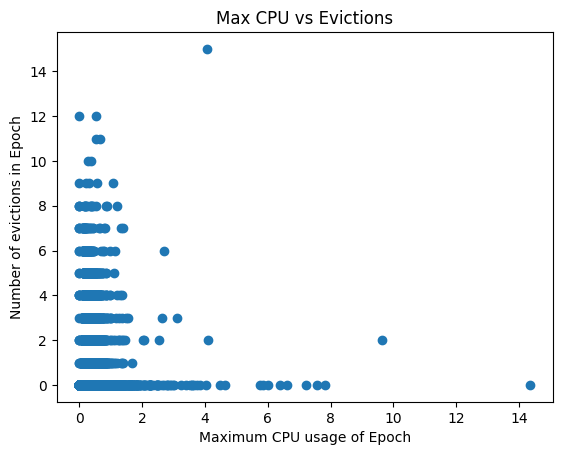

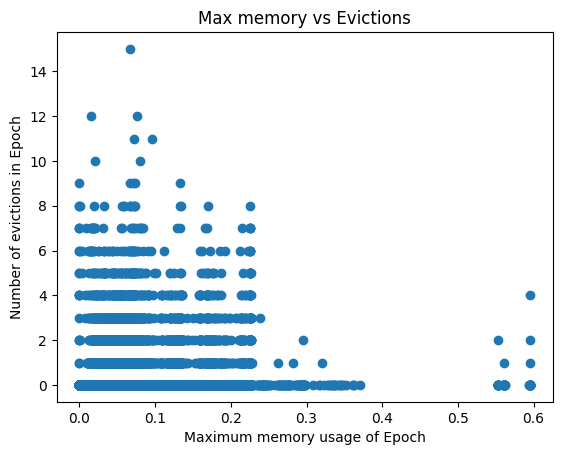

Text(0, 0.5, 'Number of evictions in Epoch')

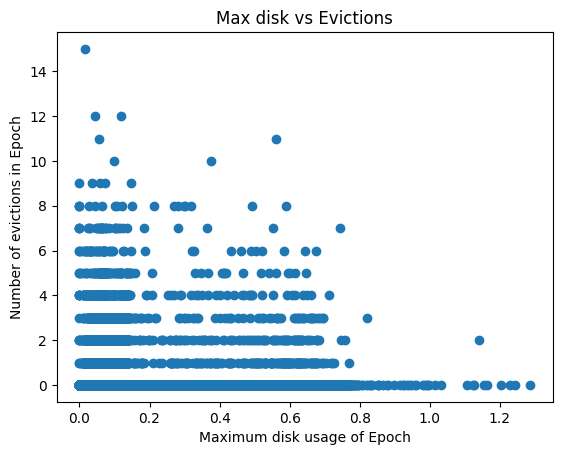

In [38]:
plt.scatter(*cpu)
plt.title("Max CPU vs Evictions")
plt.xlabel("Maximum CPU usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*memory)
plt.title("Max memory vs Evictions")
plt.xlabel("Maximum memory usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*disk)
plt.title("Max disk vs Evictions")
plt.xlabel("Maximum disk usage of Epoch")
plt.ylabel("Number of evictions in Epoch")

## Additional Questions (added by us)

Here are the final 2 questions that we came up with, each have their precisions to explain what it is we are looking for.

### 1 - Study of the relation between Scheduling Class and Dead Time

The Google documentation tells us that scheduling classes have different levels of latency, with 3 supposedly having lower latency than 0. It also tells us that when a task dies (failed, evicted, etc.), the scheduler tries to submit it again as soon as possible. As such, we can verify the first statement by looking at the average time spent being dead for each classes. We should expect class 0 to have the most, and class 3 the least.

First, let's remind ourself of the distribution of scheduling classes : 

In [40]:
distribution = None
try :
    distribution = job_scheduling_classes
except NameError:
    distribution = job_events \
        .filter(lambda job_event: job_events_get['event type'](job_event) == 0) \
        .map(lambda event: (job_events_get['job ID'](event), job_events_get['scheduling class'](event))) \
        .distinct() \
        .map(lambda job_class: (job_class[1], 1)) \
        .reduceByKey(add) \
        .collect()

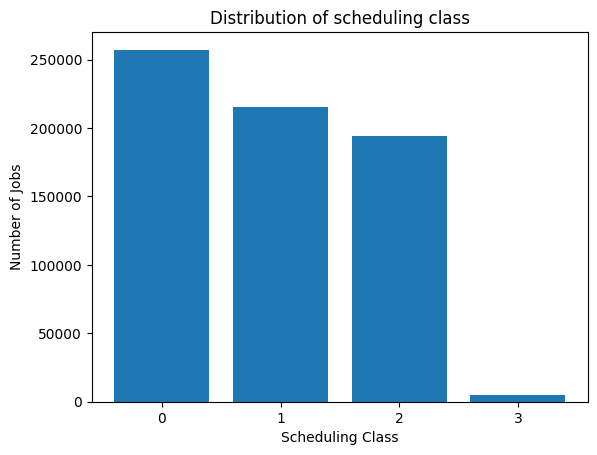

In [41]:
classes, hist = zip(*distribution)
classes = [str(e) for e in classes]
plt.bar(classes, hist)
plt.title("Distribution of scheduling class")
plt.xlabel("Scheduling Class")
plt.ylabel("Number of Jobs")
plt.show()

Now let us form the timeline of each jobs, then perform the necessary transformations to have the average death time for each class.

In [42]:
jobs_timeline = job_events \
    .filter(lambda event: job_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (job_events_get['job ID'](event),job_events_get['scheduling class'](event)),
        (job_events_get['time'](event), job_events_get['event type'](event))
        )
    ) \
    .groupByKey() \
    .mapValues(list) \
    .cache()

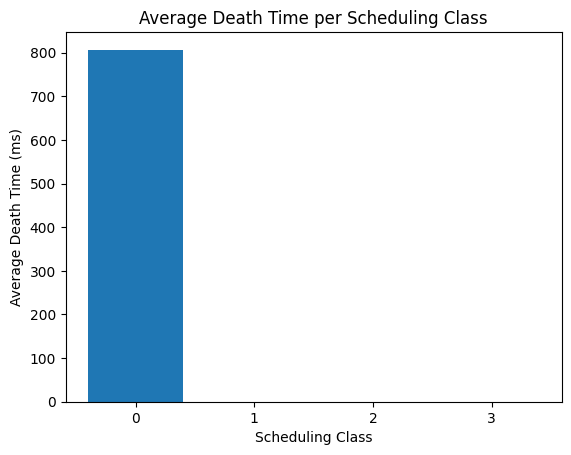

In [43]:
def death_times(s_class, timeline):
    timeline.sort(key=lambda x: x[0])
    all_deaths = []
    for i in range(1,len(timeline)):
        if timeline[i-1][1] in {2,3,4,5,6} and timeline[i][1] == 0:
            all_deaths += [(s_class,timeline[i][0] - timeline[i-1][0])]
    if all_deaths == []:
        return [(s_class,0)]
    return all_deaths

average_death_duration_per_class = jobs_timeline \
    .flatMap(lambda job: death_times(job[0][1],job[1])) \
    .aggregateByKey(
        (0,0),
        lambda acc, data : (acc[0] + data, acc[1] + 1),
        lambda acc1, acc2 : (acc1[0] + acc2[0], acc1[1] + acc2[1])
    ).mapValues(lambda v: v[0]/v[1])

_ , data_death_time = zip(*average_death_duration_per_class.sortByKey().collect())
plt.bar([str(c) for c in range(4)],data_death_time)
plt.title("Average Death Time per Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Average Death Time (ms)")
plt.show()

We can see from the above graph and raw data that scheduling class 0 is the only class with any visible latency, which is slightly unexpected but does not contradict what was said in the google documentation.

### 2 - Task priority impact 

Is there a positive correlation between a task priority and the ratio of its life spent running. Logic would say that it does, as this is what we would expect the scheduler to do.

Preliminary questions:
- Can a task change priority level ?
- Do some tasks not have a FINISH (4) event at the end of their timeline ?

In [44]:
nb_tasks_several_priorities = task_events.map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), {task_events_get['priority'](event)})) \
    .reduceByKey(lambda p1, p2: p1 | p2) \
    .filter(lambda task: len(task[1])>1) \
    .count()

print(f"There are {nb_tasks_several_priorities} tasks that have changed priorities.")

tasks_last_event_distribution = task_events \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .reduceByKey(lambda e1,e2: e1 if e1[0] > e2[0] else e2) \
    .map(lambda event : (event[1][1],1)) \
    .reduceByKey(add) \
    .sortBy(lambda e: e[0]) \
    .collect()

print(f"The distribution of last events are as follows :\n{tabulate(tasks_last_event_distribution)}")


There are 142 tasks that have changed priorities.


The distribution of last events are as follows :
-  -------
0    21292
1   128291
2     1053
3     3339
4  1554453
5   731765
6      486
8      200
-  -------


Considering what we see, we need to filter events that have actually finished to have a relevant dataset for our question, as a task with high priority could have had a short life without running, getting a poor ratio as a result. We also need to filter by the timeline that starts with a submit, to prevent the cases where where a task changed priorities, and therefore doesn't have a full timeline.

Now that we know that, we just need to look at each task's timelines (similar to how we did it in question 2) and determine its running time, and whole life. 
We will need to determine the running time out of all it's life. The running time is the time between the events SCHEDULE (1) and either EVICT (2), FINISHED (4), FAIL (3), KILL (5), or LOST (6). The last 3 events can indeed happen even if the task has finished, as the Google documentation specifies, if those events happens, the scheduler will try to re-submit the task.

We will filter out the updates events, as they do not change the running status of our tasks.

In [45]:
tasks_timeline = task_events \
    .filter(lambda event: task_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event), task_events_get['priority'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .filter(lambda task: task[1][-1][1] == 4 and task[1][0][1] == 0) \
    .cache()

# print(f"We have a total of {tasks_timeline.count()} tasks timelines.")

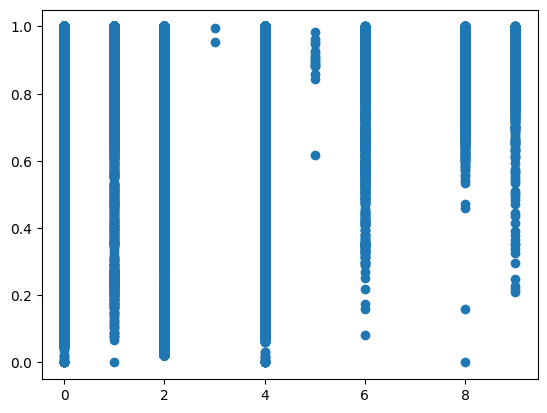

In [46]:
def running_ratio(timeline):
    timeline.sort(key=lambda x: x[0])
    total_time = timeline[-1][0] - timeline[0][0]
    if total_time==0 :
        total_time = 1
    running_time = 0
    for i in range(1,len(timeline)):
        if timeline[i-1][1] == 1 and timeline[i][1] in {2,3,4,5,6}:
            running_time += timeline[i][0] - timeline[i-1][0]
    return float(running_time) / float(total_time)

tasks_ratio = tasks_timeline.map(lambda task: (task[0][2],running_ratio(task[1])))

plt.scatter(*zip(*tasks_ratio.collect()))
plt.show()

Seeing all points does not help us, so let's see the average for each priority level.

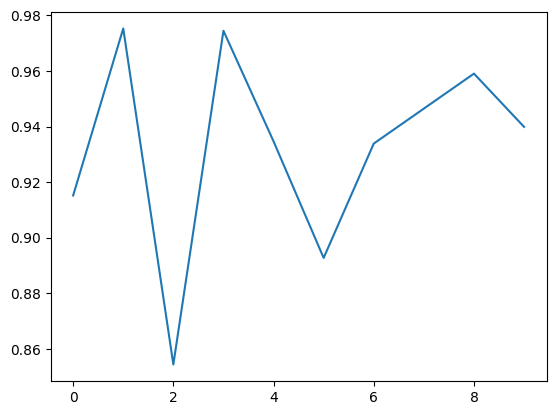

In [47]:
tasks_average_ratio = tasks_ratio \
    .map(lambda task: (task[0],(task[1],1))) \
    .reduceByKey(lambda t1,t2: (t1[0]+t2[0],t1[1]+t2[1])) \
    .map(lambda task: (task[0],task[1][0]/task[1][1]))

plt.plot(*zip(*tasks_average_ratio.collect()))
plt.show()

These results are very unexpected, the google documentation (page 8, Task events table section) clearly states that 0 is the lowest priority. But the document also states that there are 3 priority categories :
- free : lowest priority
- production : highest priorities
- monitoring : special category for jobs that monitor others

The graph we see might be a result of those 3 ranges, if we try to perform the above computations with more tables (currently 40, below with 100), we obtain the graph below :

![](priority_runtime_100tables.png)

Seeing this new graph, we can have a better guess as to what the 3 categories are :
- 0 to 2 -> *free* (low overall runtime compared to next section)
- 3 to 8 -> *production* (consistently high overall runtime)
- 9 to 11 -> *monitoring* (big drop in runtime)

The number itself does not have much meaning then, except assigning you to one of the categories. As for the big drop in runtime for the last category, maybe monitoring has low ratios because it gets evicted often for long period monitoring, it does not need to run often, and therefore produces a lower ratio overall.

# Extension Work : DataFrame Version of previous work

As an extension for our work, we decided to use PySparkSQL DataFrame object instead of the RDD. We selected a few questions with different approach, and tried to redo them using DataFrames along with tools coming from PySparkSQL. 

Here are the results of our work, with both our successes and failures.

## Starting PySparkSQL and importing the schema

To use DataFrames, we need to use the SparkSession of PySparkSQL instead of the SparkContext. PySparkSQL allows the use the tabular methods provided by DataFrames. Spark offers a DataFrame API, through their Spark SQL.

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

schema = Schema("./data/schema.csv")

## Importing tables into DataFrame

Importing .csv files into a DataFrame was a bit different from the RDD, but we found how to do it in the [documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv) :

In [6]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('machine_events')['fields']
])

machine_events_df = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(machine_events_schema) \
    .load("./data/machine_events/*.csv")

Let's see what the schema looks like, to see if it is what we expect it to be for machine events.

In [7]:
machine_events_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- machine_ID: long (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- platform_ID: string (nullable = true)
 |-- CPUs: float (nullable = true)
 |-- Memory: float (nullable = true)



## Distribution of CPU Capacity (Q1)

This question is simple enough to have a small expression that looks like what we did for RDDs :

In [18]:
creation_events = machine_events_df \
    .filter(machine_events_df.event_type == 0) \
    .filter(machine_events_df.CPUs.isNotNull())

cpu_counts = creation_events \
    .groupBy("machine_ID") \
    .agg({"time":"max","CPUs":"max"}) \
    .groupBy("max(CPUs)") \
    .count()

cpu_counts.show()

+---------+-----+
|max(CPUs)|count|
+---------+-----+
|     0.25|  123|
|      0.5|11636|
|      1.0|  796|
+---------+-----+



It is still different enough, as we have to use an aggregation function after the *groupBy*. Furthermore, the renaming of Columns is something we need to account for, except if we want to rename them after each operations with *withColumnRenamed*.

We can also use sql queries for the same purpose :

In [19]:
creation_events.createOrReplaceTempView("creation_events")

spark.sql("SELECT cpu as CPU_Value, COUNT(*) AS Number_Of_Machines "
            "FROM ("
                "SELECT machine_ID AS ID, max(time), max(CPUs) AS cpu "
                "FROM creation_events "
                "GROUP BY id "
            ") "
            "GROUP BY CPU_Value;").show()

+---------+------------------+
|CPU_Value|Number_Of_Machines|
+---------+------------------+
|     0.25|               123|
|      0.5|             11636|
|      1.0|               796|
+---------+------------------+



The above *select* gave small difficulties concerning the fact that we needed 2 groupBy back to back, that we were able to do via an embedded query from which we do the final groupBy. 

## Percentage of lost computational power (Q2)

We had the idea of doing this question because we thought it could be an interesting challenge, as it wasn't too hard to do it with RDD, but we didn't see how to do it with DataFrames at first. We nearly abandoned this question as an example of something we didn't manage to do with DataFrames but we managed to find a solution. This took a while.

Here are the approach we took to tackle this question with DataFrames.

#### Preliminary exploration

We first need to check a few things to know what to account for in our operations. First off, let us verify if the value of CPUs can be null :

In [9]:
machine_events_df.createOrReplaceTempView("machine_events")

bad_cpu_machines = spark.sql("SELECT DISTINCT machine_ID "
                             "FROM machine_events "
                             "WHERE CPUs IS NULL")
bad_cpu_machines.count()

32

Indeed it can, now let us see the maximum number of events on each machine :

In [12]:
spark.sql(
    "SELECT COUNT(*) as n_events FROM machine_events "
    "WHERE CPUs IS NOT NULL "
    "GROUP BY machine_ID "
    "ORDER BY n_events DESC "
    "LIMIT 1"
    ).show()

+--------+
|n_events|
+--------+
|     330|
+--------+



A machine has therefore at most 330 events, it is small enough that python can handle one machine. We'll therefore group the list of events, CPUs rates and timestamps for each machine IDs, then operate on them to determine the lost computational power of the cluster.

#### Machine timelines

We here group a list of timestamps, CPU rates, and event types, for later use to determine lost computational power.

In [127]:
grouped_machine_events = machine_events_df \
    .orderBy(machine_events_df['time']) \
    .groupBy(machine_events_df['machine_ID']) \
    .agg(
        F.collect_list('time').alias('time'),
        F.collect_list('event_type').alias('event_type'),
        F.max('CPUs').alias('cpu')) \
    .filter(F.col('cpu').isNotNull())

In [156]:
grouped_machine_events.show(5)

+----------+--------------------+----------+---+
|machine_ID|                time|event_type|cpu|
+----------+--------------------+----------+---+
|         5|[835150655707, 83...| [1, 0, 0]|0.5|
|         6|                 [0]|       [0]|0.5|
|         7|                 [0]|       [0]|0.5|
|        10|[1306164355566, 1...| [1, 0, 0]|0.5|
|        13|[2447693838527, 2...| [1, 0, 0]|0.5|
+----------+--------------------+----------+---+
only showing top 5 rows



#### Power Lost Computation

And now, we arrive at the problematic part. DataFrames are very powerful on many regards, but a weakness that we haven't found a solution to, is the fact that operations are done on columns, which is fine if there exists functions that we need in PySparkSQL. 

The idea we had was to add a new column with the method *withColumn*, and apply operations on the column time, event_type, and CPUs, but it wasn't a matter of just adding 3 numbers, or even do some simple vector operations. We need to retrieve the arrays inside each row, and apply operations on multiple element of the arrays at once (test 2 consecutive events, access 2 timestamps to get durations).

We found a solution by defining a *udf function*, which enables us to do an operation close to "mapping" :

In [176]:
from pyspark.sql.functions import udf, col

# Computing the lost power for each machine
def lost_power(time, event, cpu):
  acc = 0
  # The following test is here because some arrays had their first elements at the end, bu we could not figure out why
  if time[-1]>time[0]:
    for i in range(1,len(time)):
      if event[i-1] ==1 and event[i] == 0:
        acc += (time[i]-time[i-1]) * (cpu)
  else :
    for i in range(len(time)-1):
      if event[(i-1)%len(time)] ==1 and event[i] == 0:
        acc += (time[i]-time[(i-1)%len(time)]) * (cpu)
  return acc

# Finding the total power output of this machine
def total_power(time, event, cpu, max_time):
  if len(time)==1:
    return (max_time - time[0]) * cpu

  last_event_delete = False
  if time[-1]>time[0]:
    if event[-1] == 1:
      last_event_delete = True
  else :
    if event[-2] == 1:
      last_event_delete = True
  
  if last_event_delete:
    return (max(time) - min(time)) * cpu
  return (max_time - min(time)) * cpu

lost_power_udf = udf(lambda time, event, cpu: lost_power(time,event,cpu))
total_power_udf = udf(lambda time, event, cpu, max_time: total_power(time,event,cpu,max_time))

max_time_tmp = machine_events_df.select(F.max(machine_events_df.time)).collect()[0].asDict()['max(time)']

machine_lost_power = grouped_machine_events \
  .withColumn('max_time', F.lit(max_time_tmp)) \
  .withColumn('lost_power', lost_power_udf(col("time"),col("event_type"),col("cpu"))) \
  .withColumn('total_power', total_power_udf(col("time"),col("event_type"),col("cpu"),col("max_time")))

In [177]:
machine_lost_power.show(5)

+----------+--------------------+----------+---+-------------+-------------+------------------+
|machine_ID|                time|event_type|cpu|     max_time|   lost_power|       total_power|
+----------+--------------------+----------+---+-------------+-------------+------------------+
|         5|[835150655707, 83...| [1, 0, 0]|0.5|2506135493517|4.871238785E8|1.2530677467585E12|
|         6|                 [0]|       [0]|0.5|2506135493517|            0|1.2530677467585E12|
|         7|                 [0]|       [0]|0.5|2506135493517|            0|1.2530677467585E12|
|        10|[1306164355566, 1...| [1, 0, 0]|0.5|2506135493517| 4.99363174E8|1.2530677467585E12|
|        13|[2447693838527, 2...| [1, 0, 0]|0.5|2506135493517|4.986401075E8|1.2530677467585E12|
+----------+--------------------+----------+---+-------------+-------------+------------------+
only showing top 5 rows



As we can see, we needed to use the udf function to be able to do what we wanted. Now, we just need to do the final computation through a simple select and we are done.

In [183]:
percentage_of_lost_power = machine_lost_power.select(F.sum(col("lost_power")) / F.sum(col("total_power"))).collect()[0].asDict()['(sum(lost_power) / sum(total_power))']

print(f"The cluster lost around {percentage_of_lost_power*100:0.5f}% of power overall.")

The cluster lost around 0.48275% of power overall.


## Do tasks from the same job run on the same machine (Q5)

For this question, we need to group task events by job IDs, then see how many *distinct* machine IDs we have, then do a histogram of it. With RDDs, we did it with maps and reduce using sets operations to account for distinct machine_ID. 

Using DataFrames, we are able to take advantage of groupBy then agg functions, along with column functions to make the process more straight forward.

Let's first load the task events :

In [21]:
# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
from pyspark.sql.types import BooleanType

field_to_spark_type = {
    'time': LongType,
    'missing info': LongType,
    'job ID': LongType,
    'task index': IntegerType,
    'machine ID': LongType,
    'event type': IntegerType,
    'user': StringType,
    'scheduling class': IntegerType,
    'priority': IntegerType,
    'CPU request': FloatType,
    'memory request': FloatType,
    'disk space request': FloatType,
    'different machines restriction': BooleanType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
task_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('task_events')['fields']
])

task_events_df = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(task_events_schema) \
    .load("./data/task_events")

In [23]:
task_events_df.show(5)

+-----------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|       time|missing_info|    job_ID|task_index|machine_ID|event_type|                user|scheduling_class|priority|CPU_request|memory_request|disk_space_request|different_machines_restriction|
+-----------+------------+----------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|95813803204|        null|6238340468|      2025| 317469463|         2|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          null|
|95813803212|        null|6238340468|      2025|      null|         0|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          null|
|95813803214|        null

We note from the above display and the schema file that the attribute *machine_ID* can be *null*, as such, we need to filter it out before other operations.

In [13]:
different_machines_histogram = task_events.filter(task_events.machine_ID.isNotNull())\
    .groupBy("job_ID") \
    .agg(F.count_distinct(task_events.machine_ID)) \
    .groupBy("count(machine_ID)") \
    .agg({"job_ID":"count"}) \
    .orderBy("count(machine_ID)") \
    .withColumnRenamed("count(machine_ID)","nb_machine") \
    .withColumnRenamed("count(job_ID)","count") \
    .cache()

different_machines_histogram.show()

+----------+-----+
|nb_machine|count|
+----------+-----+
|         1|37656|
|         2| 3228|
|         3|  665|
|         4|  296|
|         5|  407|
|         6|  407|
|         7|  199|
|         8|  158|
|         9|  472|
|        10|  235|
|        11|  848|
|        12|  152|
|        13|   85|
|        14|  324|
|        15| 1031|
|        16|  231|
|        17|   79|
|        18|  107|
|        19|   45|
|        20|  110|
+----------+-----+
only showing top 20 rows



Let us gather the data into a chart to see these results in a better light.

In [14]:
iterator = different_machines_histogram.toLocalIterator()
X = []
Y = []

for row in iterator:
    d = row.asDict()
    X += [d["nb_machine"]]
    Y += [d["count"]]

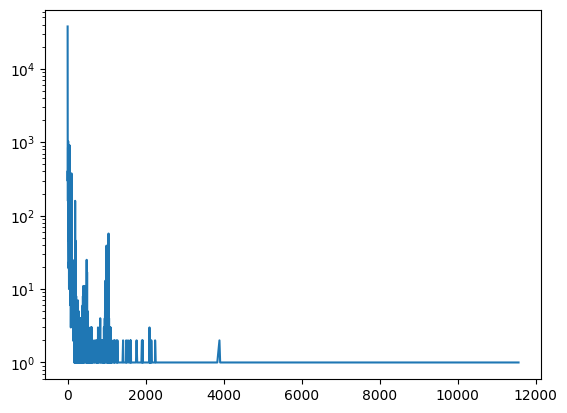

In [15]:
plt.plot(X,Y)
plt.yscale("log")
plt.show()